In [20]:
import numpy as np
import igl
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors
import mpl_toolkits.mplot3d 
from icosphere import icosphere


ModuleNotFoundError: No module named 'meshplot'

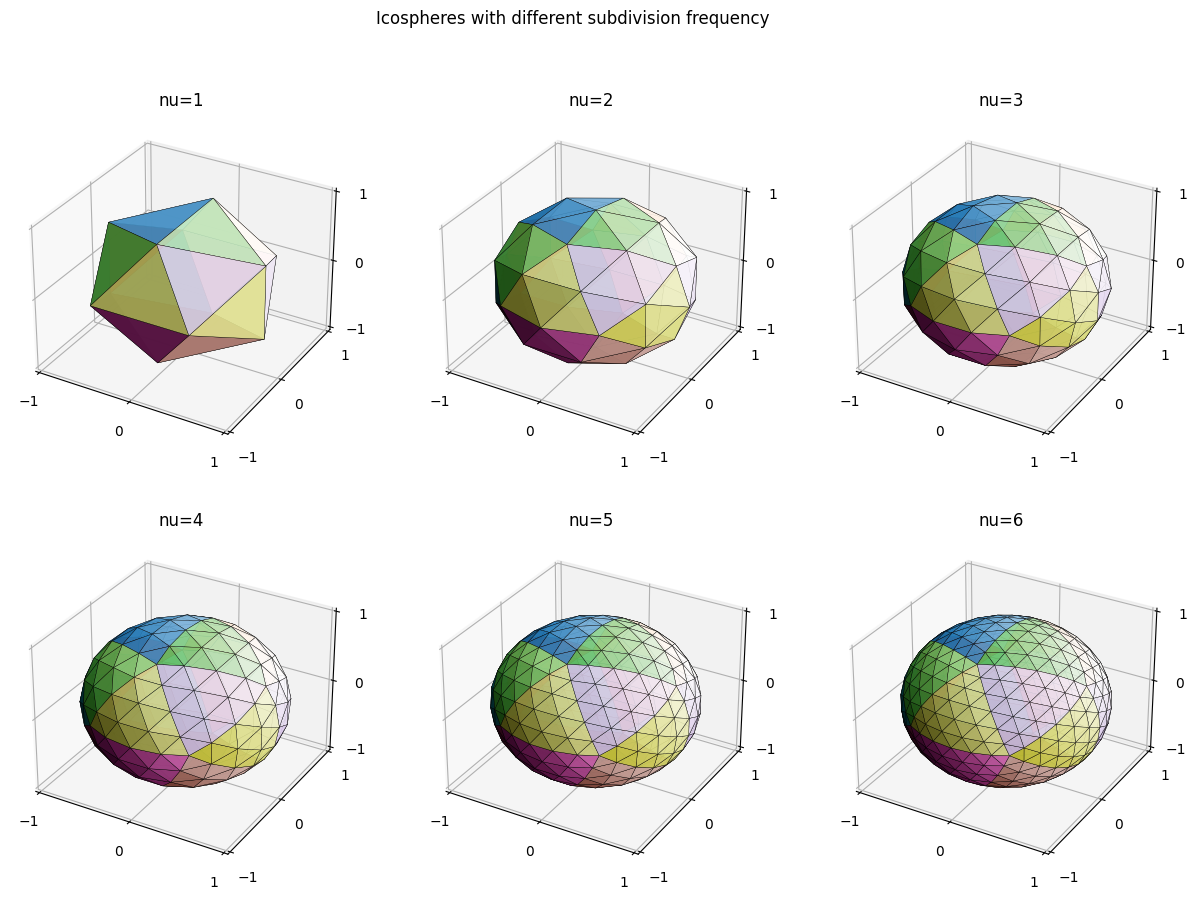

In [9]:
# source: https://github.com/vedranaa/icosphere/blob/main/Example_in_matplotlib.ipynb

fig = plt.figure(figsize=(15, 10))
for nu in range(1,7):

    vertices, faces = icosphere(nu=nu)
    
    # basic mesh color, divided in 20 groups (one for each original face)
    jet = matplotlib.cm.tab20(np.linspace(0,1,20))
    jet = np.tile(jet[:,:3], (1, faces.shape[0]//20))
    jet = jet.reshape(faces.shape[0], 1, 3)

    # computing face shading intensity based on face normals  
    face_normals = np.cross(vertices[faces[:,1]]-vertices[faces[:,0]], 
                            vertices[faces[:,2]]-vertices[faces[:,0]])
    face_normals /= np.sqrt(np.sum(face_normals**2, axis=1, keepdims=True))               
    light_source = matplotlib.colors.LightSource(azdeg=60, altdeg=30)
    intensity = light_source.shade_normals(face_normals)

    # blending face colors and face shading intensity
    rgb = light_source.blend_hsv(rgb=jet, intensity=intensity.reshape(-1,1,1))   

    # adding alpha value, may be left out
    rgba = np.concatenate((rgb, 0.9*np.ones(shape=(rgb.shape[0],1,1))), axis=2) 

    # creating mesh with given face colors
    poly = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
    poly.set_facecolor(rgba.reshape(-1,4)) 
    poly.set_edgecolor('black')
    poly.set_linewidth(0.25)

    # and now -- visualization! 
    ax = fig.add_subplot(2,3,nu, projection='3d')                  

    ax.add_collection3d(poly) 
        
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_zlim(-1,1)
    
    ax.set_xticks([-1,0,1])
    ax.set_yticks([-1,0,1])
    ax.set_zticks([-1,0,1])
    
    ax.set_title(f'nu={nu}')

fig.suptitle('Icospheres with different subdivision frequency')
plt.show()

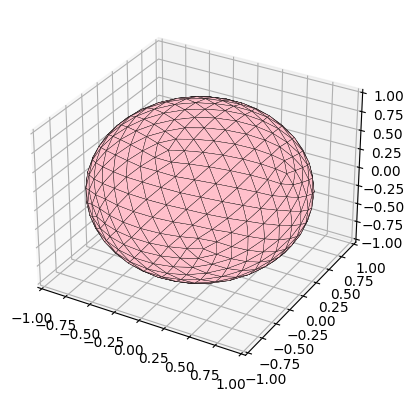

In [102]:
n = 7
vertices, faces = icosphere(n)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sphere = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
sphere.set_facecolor('pink')
sphere.set_edgecolor('black')
sphere.set_linewidth(0.25)

ax.add_collection3d(sphere)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()

In [103]:
# Geodetic distance between two points 
print(vertices.shape, faces.shape)

vertices = vertices.astype(float)
faces = faces.astype(int)

vs, vt = np.random.randint(0, len(vertices), 2)
fs, ft = np.random.randint(0, len(faces), 2)

vs, vt, fs, ft = np.array([vs]), np.array([vt]), np.array([fs]), np.array([ft])

# finding the shortest path between the two points
dist = igl.exact_geodesic(vertices, faces, vs, vt)
print(dist)


(492, 3) (980, 3)
2.779982974193303


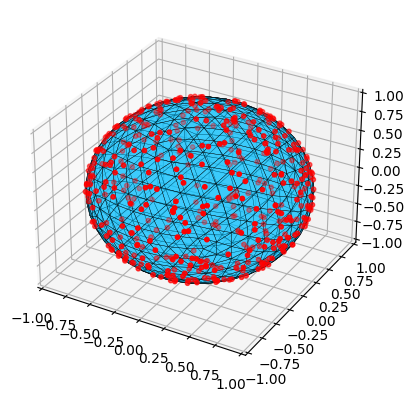

In [126]:
# Distance fields
# Generate some sample points
def samples(n):
    # Generating z coordinates with radius = 1
    z = np.random.uniform(-1,1,n)

    # Generating azimuthal angles
    phi = np.random.uniform(0,2*math.pi,n)

    # Generating x and y coordinates
    x = np.sqrt(1-z**2)*np.cos(phi)
    y = np.sqrt(1-z**2)*np.sin(phi)
    samples = np.array([x,y,z]).T
    return samples

points = samples(500)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sphere = mpl_toolkits.mplot3d.art3d.Poly3DCollection(vertices[faces])
sphere.set_facecolor('deepskyblue')
sphere.set_edgecolor('black')
sphere.set_alpha(0.5)
sphere.set_linewidth(0.25)

ax.add_collection3d(sphere)
ax.scatter(points[:,0], points[:,1], points[:,2], c='red', s=10)

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
plt.show()


In [133]:

# Compute the signed distance and closest face for each point
dist = igl.signed_distance(points, vertices, faces)

print(dist[1].shape)

def pairDistances(samples, vertices, faces):
    npts = np.shape(samples)[0]
    dist = []
    for i in range(npts):
        d = igl.exact_geodesic(vertices, faces, vs, vt)
        dist.append(d)
    return dist

pair_dist = pairDistances(points, vertices, faces)
print(pair_dist.shape)

(500,)


AttributeError: 'list' object has no attribute 'shape'